In [3]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import time
from itertools import combinations, product
import copy
import functools
import random
import ast
import random
import pickle

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [169]:
def get_distance_matrix(df):
    coords = df[['x', 'y']].to_numpy()
    
    distance_matrix = np.round(squareform(pdist(coords, 'euclidean')))
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix


def random_search(distance_matrix):
    n = len(distance_matrix)
    
    solution = list(range(n))
    np.random.shuffle(solution)
    
    return solution[:(n//2)]


def get_total_cost(solution, distance_matrix, costs):
    assert len(solution) * 2 == len(distance_matrix)
    total_cost = 0
    
    for i in range(len(solution)-1):
        total_cost += distance_matrix[solution[i], solution[i+1]] + costs[solution[i+1]]
        
    total_cost += distance_matrix[solution[-1], solution[0]] + costs[solution[0]]
        
    return total_cost


In [170]:
def compute_inter_move_delta(solution, distance_matrix, costs, idx, new_node):
    n = len(solution)
    new_solution = solution.copy()
    old_node = solution[idx]

    new = (costs[new_node] +
            distance_matrix[new_solution[idx-1], new_node] +
            distance_matrix[new_node, new_solution[(idx+1)%n]])

    old = (costs[old_node] +
             distance_matrix[new_solution[idx-1], old_node] +
             distance_matrix[old_node, new_solution[(idx+1)%n]])

    delta = new - old
    new_solution[idx] = new_node

    return new_solution, delta



def compute_intra_move_delta(solution, distance_matrix, indices, backward=False):
    ## without roll/shift to initial form
    n = len(solution)
    i, j = indices
    
    if i >= j: raise Exception('Wrong indices, i >= j')
    if j >= n: raise Exception('Wrong indices, j >= n')
    
    if backward:
        if (i == 0 and j in (n-1, n-2)) or (j == n-1 and i in (0, 1)):
            return solution, 0
        new = distance_matrix[solution[i], solution[(j+1)%n]] + distance_matrix[solution[j], solution[i-1]]
        old = distance_matrix[solution[i-1], solution[i]] + distance_matrix[solution[j], solution[(j+1)%n]]
    else:
        if j - i in (1, 2):
            return solution, 0
        new = distance_matrix[solution[i], solution[j-1]] + distance_matrix[solution[i+1], solution[j]]
        old = distance_matrix[solution[i], solution[i+1]] + distance_matrix[solution[j-1], solution[j]]
        
    delta = new - old
    
    if backward:
        new_solution = solution[j+1:][::-1] + solution[i:j+1] + solution[:i][::-1]
    else:
        new_solution = solution[:i+1] + solution[i+1:j][::-1] + solution[j:]

    return new_solution, delta



def greedy_local_search(solution, distance_matrix, costs):
    solution = solution[:]
    n, N = len(solution), len(distance_matrix)
    solution_set = set(solution)
    outer_nodes_set = set(range(N)) - solution_set 
    
    while True:
        improved = False
        
        inter_moves = list(product(outer_nodes_set, range(n)))
        inter_moves = list(zip(['inter']*len(inter_moves), inter_moves))
        intra_moves = list(combinations(range(n), 2))
        intra_moves = list(zip(['intra']*len(intra_moves), intra_moves))
        
        moves = inter_moves + intra_moves
        random.shuffle(moves)
        
        for move_type, move in moves:
            if move_type == 'inter':
                outer_node, inner_node_idx = move
                new_solution, delta = compute_inter_move_delta(solution, distance_matrix, costs, inner_node_idx, outer_node)
                if delta < 0:
                    solution_set.add(outer_node) 
                    solution_set.remove(solution[inner_node_idx])
                    outer_nodes_set.remove(outer_node) 
                    outer_nodes_set.add(solution[inner_node_idx]) 
                    solution = new_solution[:]
                    improved = True
                    break
            elif move_type == 'intra':
                i, j = move
                new_solution, delta = compute_intra_move_delta(solution, distance_matrix, (i, j), False)
                if delta < 0:
                    solution = new_solution[:]
                    improved = True
                    break
                
        if not improved:
            return solution

In [171]:
def get_solutions(instance, distance_matrix, costs, n):
    
    solutions = []
    
    for i in range(n):
        random_solution = random_search(distance_matrix)
        solution = greedy_local_search(random_solution, distance_matrix, costs)
        solutions.append(solution)
    
    return solutions



def get_node_sim(solution1, solution2):
    return len(set(solution1).intersection(set(solution2)))



def get_edge_sim(solution1, solution2):
    edges1 = {tuple(sorted((solution1[i], solution1[(i + 1) % len(solution1)]))) for i in range(len(solution1))}
    edges2 = {tuple(sorted((solution2[i], solution2[(i + 1) % len(solution2)]))) for i in range(len(solution2))}

    return len(edges1.intersection(edges2))

In [172]:
def sim_to_best(solutions, best_solution):
    
    node_sims = []
    edge_sims = []
    
    for solution in solutions:
        node_sim = get_node_sim(solution, best_solution)
        node_sims.append(node_sim)
        edge_sim = get_edge_sim(solution, best_solution)
        edge_sims.append(edge_sim)

    return node_sims, edge_sims

In [173]:
def sim_to_avg(solutions):
    
    node_sims = []
    edge_sims = []
    n = len(solutions)
    
    for i in range(n):
        node_sim = edge_sim = 0
        for j in range(n):
            if i != j:
                node_sim += get_node_sim(solutions[i], solutions[j])
                edge_sim += get_edge_sim(solutions[i], solutions[j])
        node_sims.append(node_sim / n)
        edge_sims.append(edge_sim / n)
        
    return node_sims, edge_sims

In [195]:
def run(instance):
    
    best_solutions = {
        'TSPA': [48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 1, 177, 41, 137, 199, 192, 175, 114, 4, 77, 43, 121, 91, 50, 149, 0, 19, 178, 164, 159, 143, 59, 147, 116, 27, 96, 185, 64, 20, 71, 61, 163, 74, 113, 195, 53, 62, 32, 180, 81, 154, 144, 141, 87, 79, 194, 21, 171, 108, 15, 117, 22, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 112, 66, 6, 172, 156, 98, 190, 72, 12, 94, 89, 73, 31, 111, 14, 80, 95, 169, 8, 26, 92],
        'TSPB': [166, 59, 119, 193, 71, 44, 196, 117, 150, 162, 158, 67, 156, 91, 70, 51, 174, 140, 148, 141, 130, 142, 53, 69, 115, 82, 63, 8, 16, 18, 29, 33, 19, 190, 198, 135, 95, 172, 163, 182, 2, 5, 34, 183, 197, 31, 101, 38, 103, 131, 24, 127, 121, 179, 143, 122, 92, 26, 66, 169, 0, 57, 99, 50, 112, 154, 134, 25, 36, 165, 37, 137, 88, 55, 153, 80, 157, 145, 79, 136, 73, 185, 132, 52, 139, 107, 12, 189, 170, 181, 147, 159, 64, 129, 89, 58, 171, 72, 114, 85],
        'TSPC': [61, 113, 74, 163, 155, 62, 32, 180, 81, 154, 102, 144, 141, 87, 79, 194, 21, 171, 108, 15, 117, 53, 22, 195, 55, 36, 132, 128, 145, 76, 161, 153, 88, 127, 186, 45, 167, 101, 99, 135, 51, 5, 112, 66, 6, 172, 156, 98, 190, 72, 12, 94, 89, 73, 31, 95, 169, 110, 8, 26, 92, 48, 106, 160, 11, 152, 130, 119, 109, 189, 75, 1, 177, 41, 137, 199, 192, 43, 77, 4, 114, 91, 121, 50, 149, 0, 19, 178, 164, 159, 143, 59, 147, 116, 27, 96, 185, 64, 20, 71],
        'TSPD': [79, 145, 157, 80, 153, 4, 55, 88, 36, 25, 134, 154, 123, 165, 37, 137, 99, 92, 122, 143, 179, 121, 127, 24, 131, 103, 38, 101, 31, 197, 183, 34, 5, 128, 66, 169, 135, 198, 190, 19, 95, 172, 16, 8, 63, 82, 115, 69, 113, 53, 142, 130, 141, 148, 140, 188, 174, 51, 70, 91, 156, 3, 67, 158, 162, 150, 117, 196, 44, 71, 193, 119, 59, 166, 85, 114, 72, 171, 58, 89, 129, 64, 159, 147, 181, 170, 47, 189, 109, 12, 107, 97, 139, 52, 18, 132, 185, 73, 61, 136]
    }
    
    df = pd.read_csv(f'../data/{instance}.csv', sep=';', names=['x', 'y', 'cost'])
    costs = df.cost.to_numpy()
    distance_matrix = get_distance_matrix(df)
    
    solutions = get_solutions(instance, distance_matrix, costs, n=5)
    total_costs = [get_total_cost(solution, distance_matrix, costs) for solution in solutions]
    
    best_node_sims, best_edge_sims = sim_to_best(solutions, best_solutions[instance])
    
    avg_node_sims, avg_edge_sims = sim_to_avg(solutions)
    
    return {
        'total_costs': total_costs,
        'Node similarity to best solution': best_node_sims,
        'Edge similarity to best solution': best_edge_sims,
        'Average Node similarity to all other local optima': avg_node_sims,
        'Average Edge similarity to all other local optima': avg_edge_sims
    }

In [6]:
def correlation_coefficient(x_values, y_values):
    if len(x_values) != len(y_values):
        return "The lists are not of the same length."
    
    n = len(x_values)
    sum_x = sum(x_values)
    sum_y = sum(y_values)
    sum_x2 = sum(x**2 for x in x_values)
    sum_y2 = sum(y**2 for y in y_values)
    sum_xy = sum(x*y for x, y in zip(x_values, y_values))

    numerator = n * sum_xy - sum_x * sum_y
    denominator = ((n * sum_x2 - sum_x**2) * (n * sum_y2 - sum_y**2))**0.5

    if denominator == 0:
        return "Division by zero error in calculation."
    
    return round(numerator / denominator, 2)

In [196]:
res = run('TSPA')

In [197]:
res

{'total_costs': [79962.0, 78104.0, 77685.0, 77311.0, 76977.0],
 'Node similarity to best solution': [87, 88, 86, 88, 88],
 'Edge similarity to best solution': [44, 45, 47, 57, 46],
 'Average Node similarity to all other local optima': [68.8,
  69.2,
  68.8,
  68.0,
  70.0],
 'Average Edge similarity to all other local optima': [34.4,
  33.8,
  36.4,
  34.8,
  38.6]}

In [35]:
def get_plots(instance, res):
    
    x = res['total_costs']
    
    fig, ax = plt.subplots(2, 2, figsize=(25, 25))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(instance, fontsize=40)

    for sub_title, y in list(res.items())[1:]:
        ax[idx].scatter(x, y, s=100)
        corr = correlation_coefficient(x, y)
        
        ax[idx].set_title(sub_title, fontsize=33)
        
        ax[idx].set_xlabel(f'Total cost \n Correlation coefficient = {corr}', fontsize=22)
        ax[idx].set_ylabel('Similarity', fontsize=22)
        
        ax[idx].tick_params(axis='both', labelsize=15)
        
        ax[idx].set_ylim(30, 100)  
         
        idx += 1
        
    # plt.savefig(f'./plots/{instance}.png', dpi=300)
    plt.show()

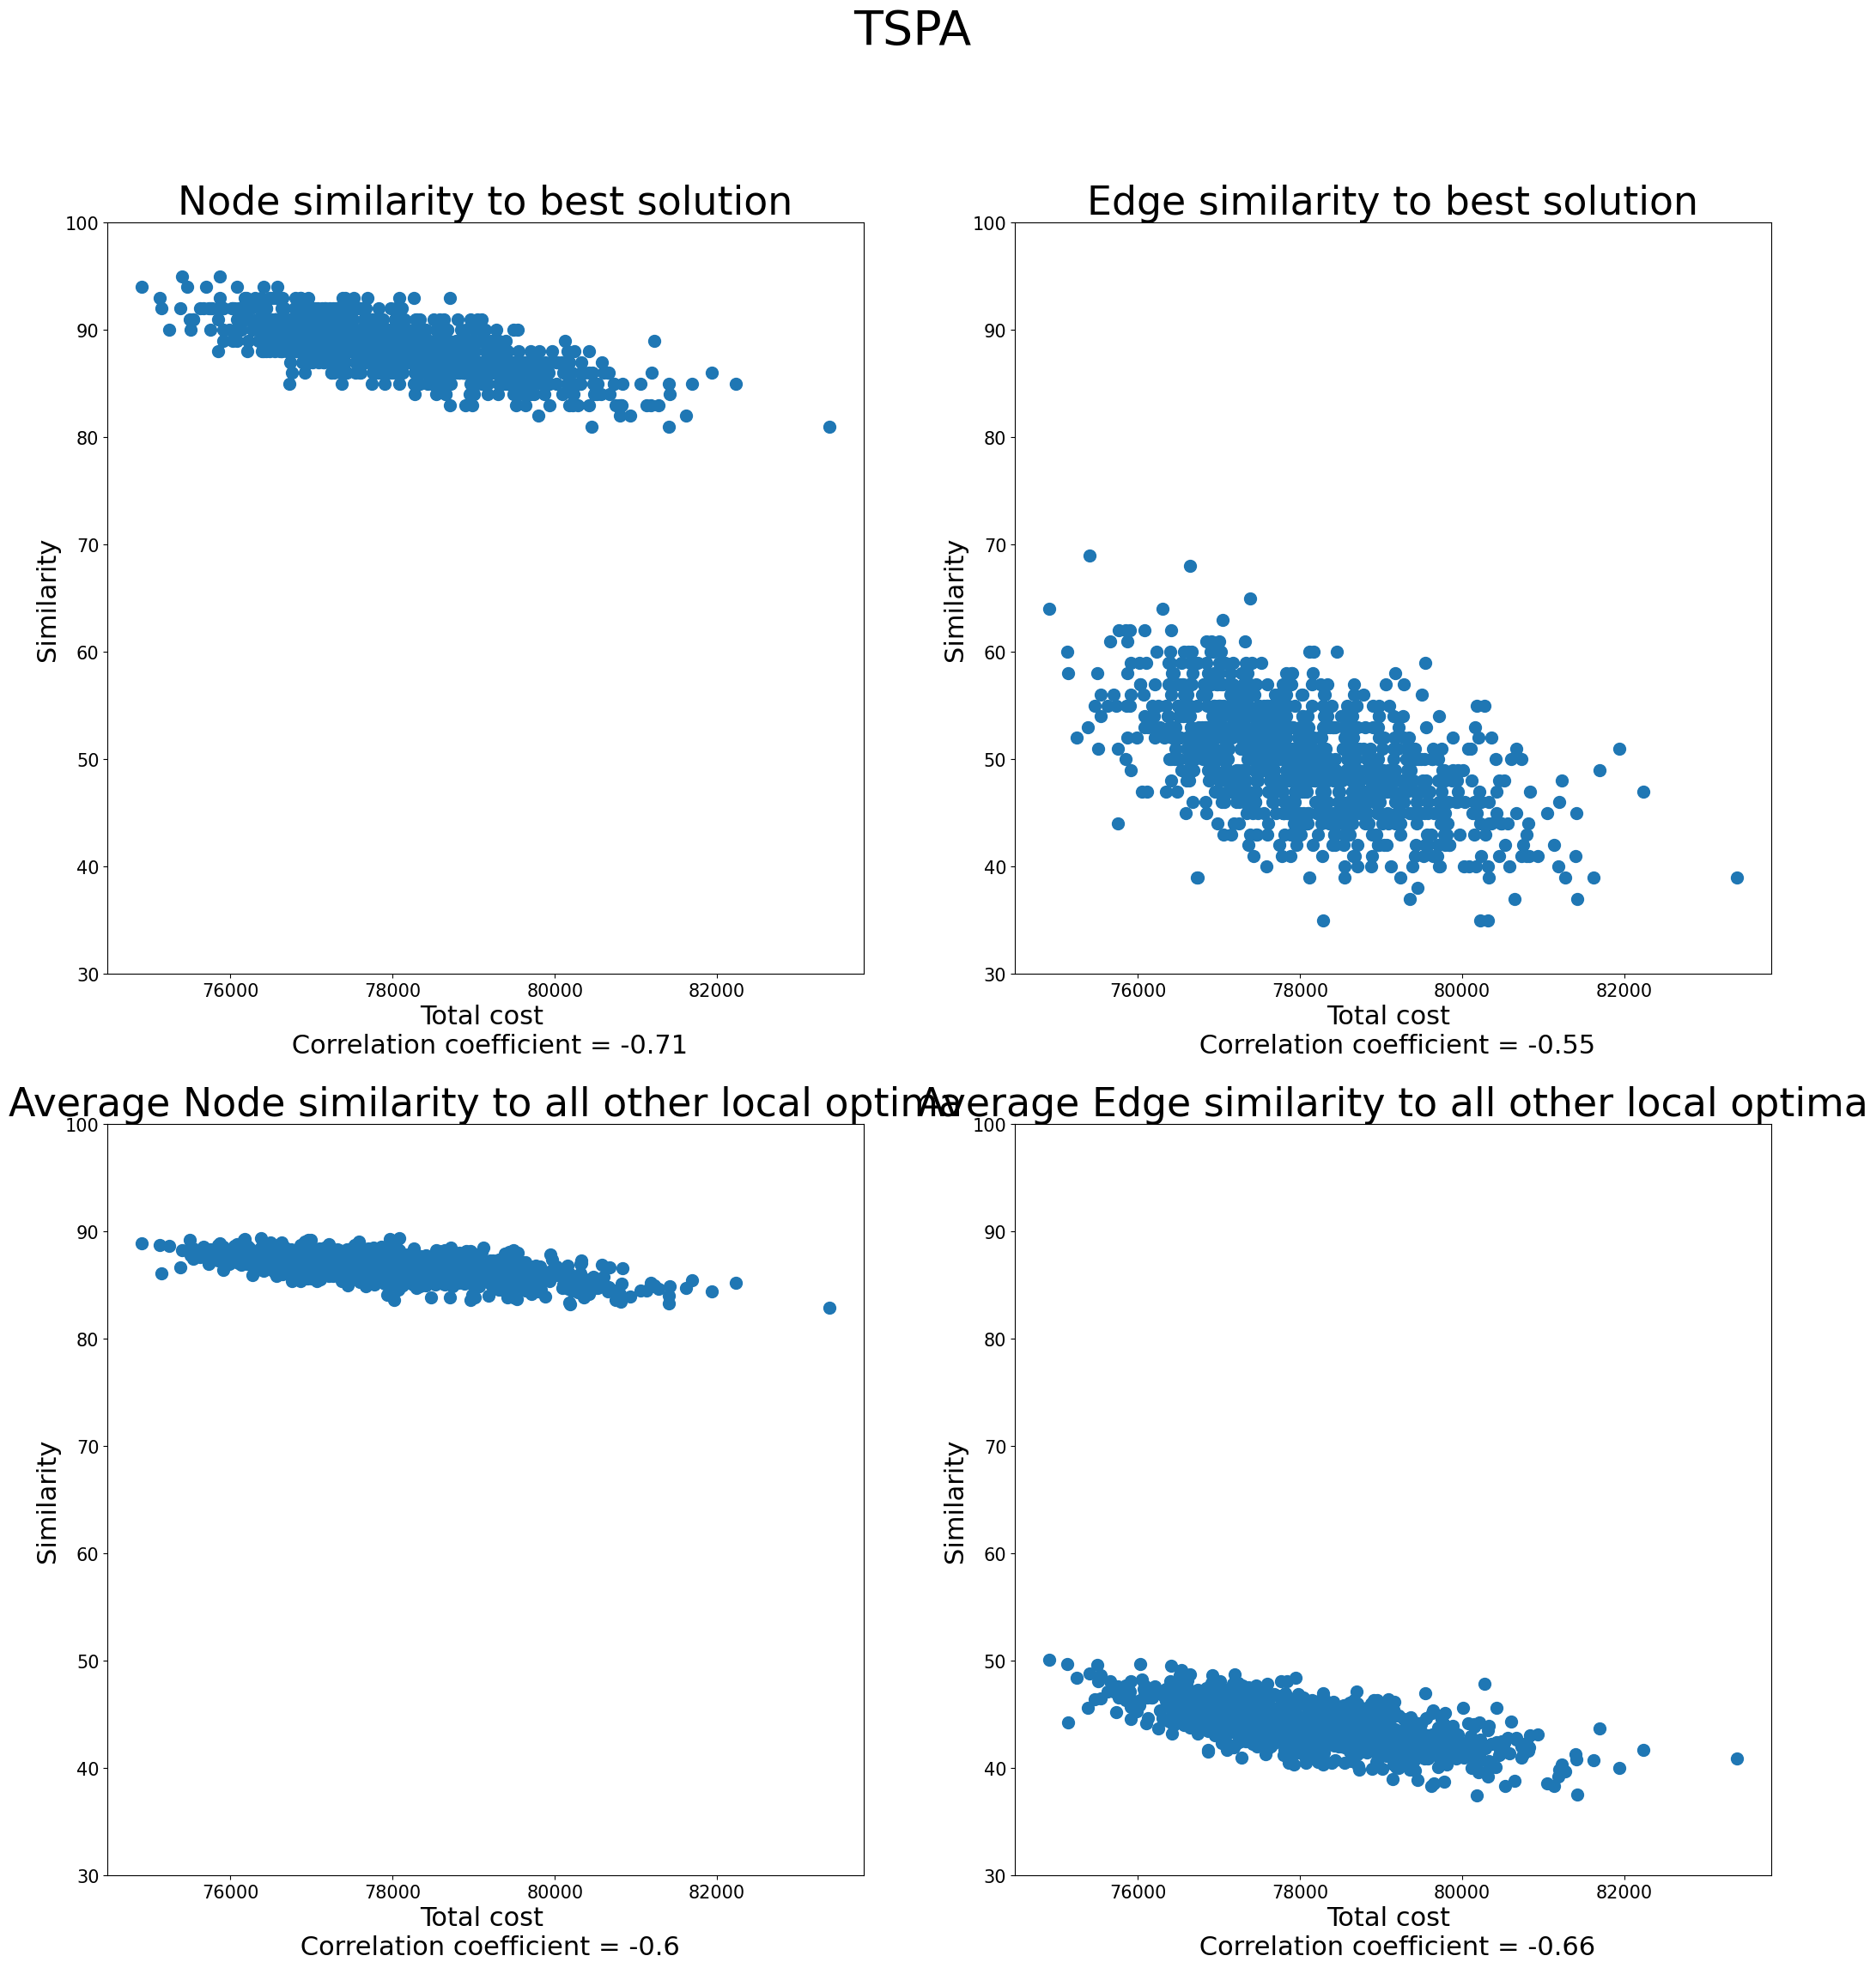

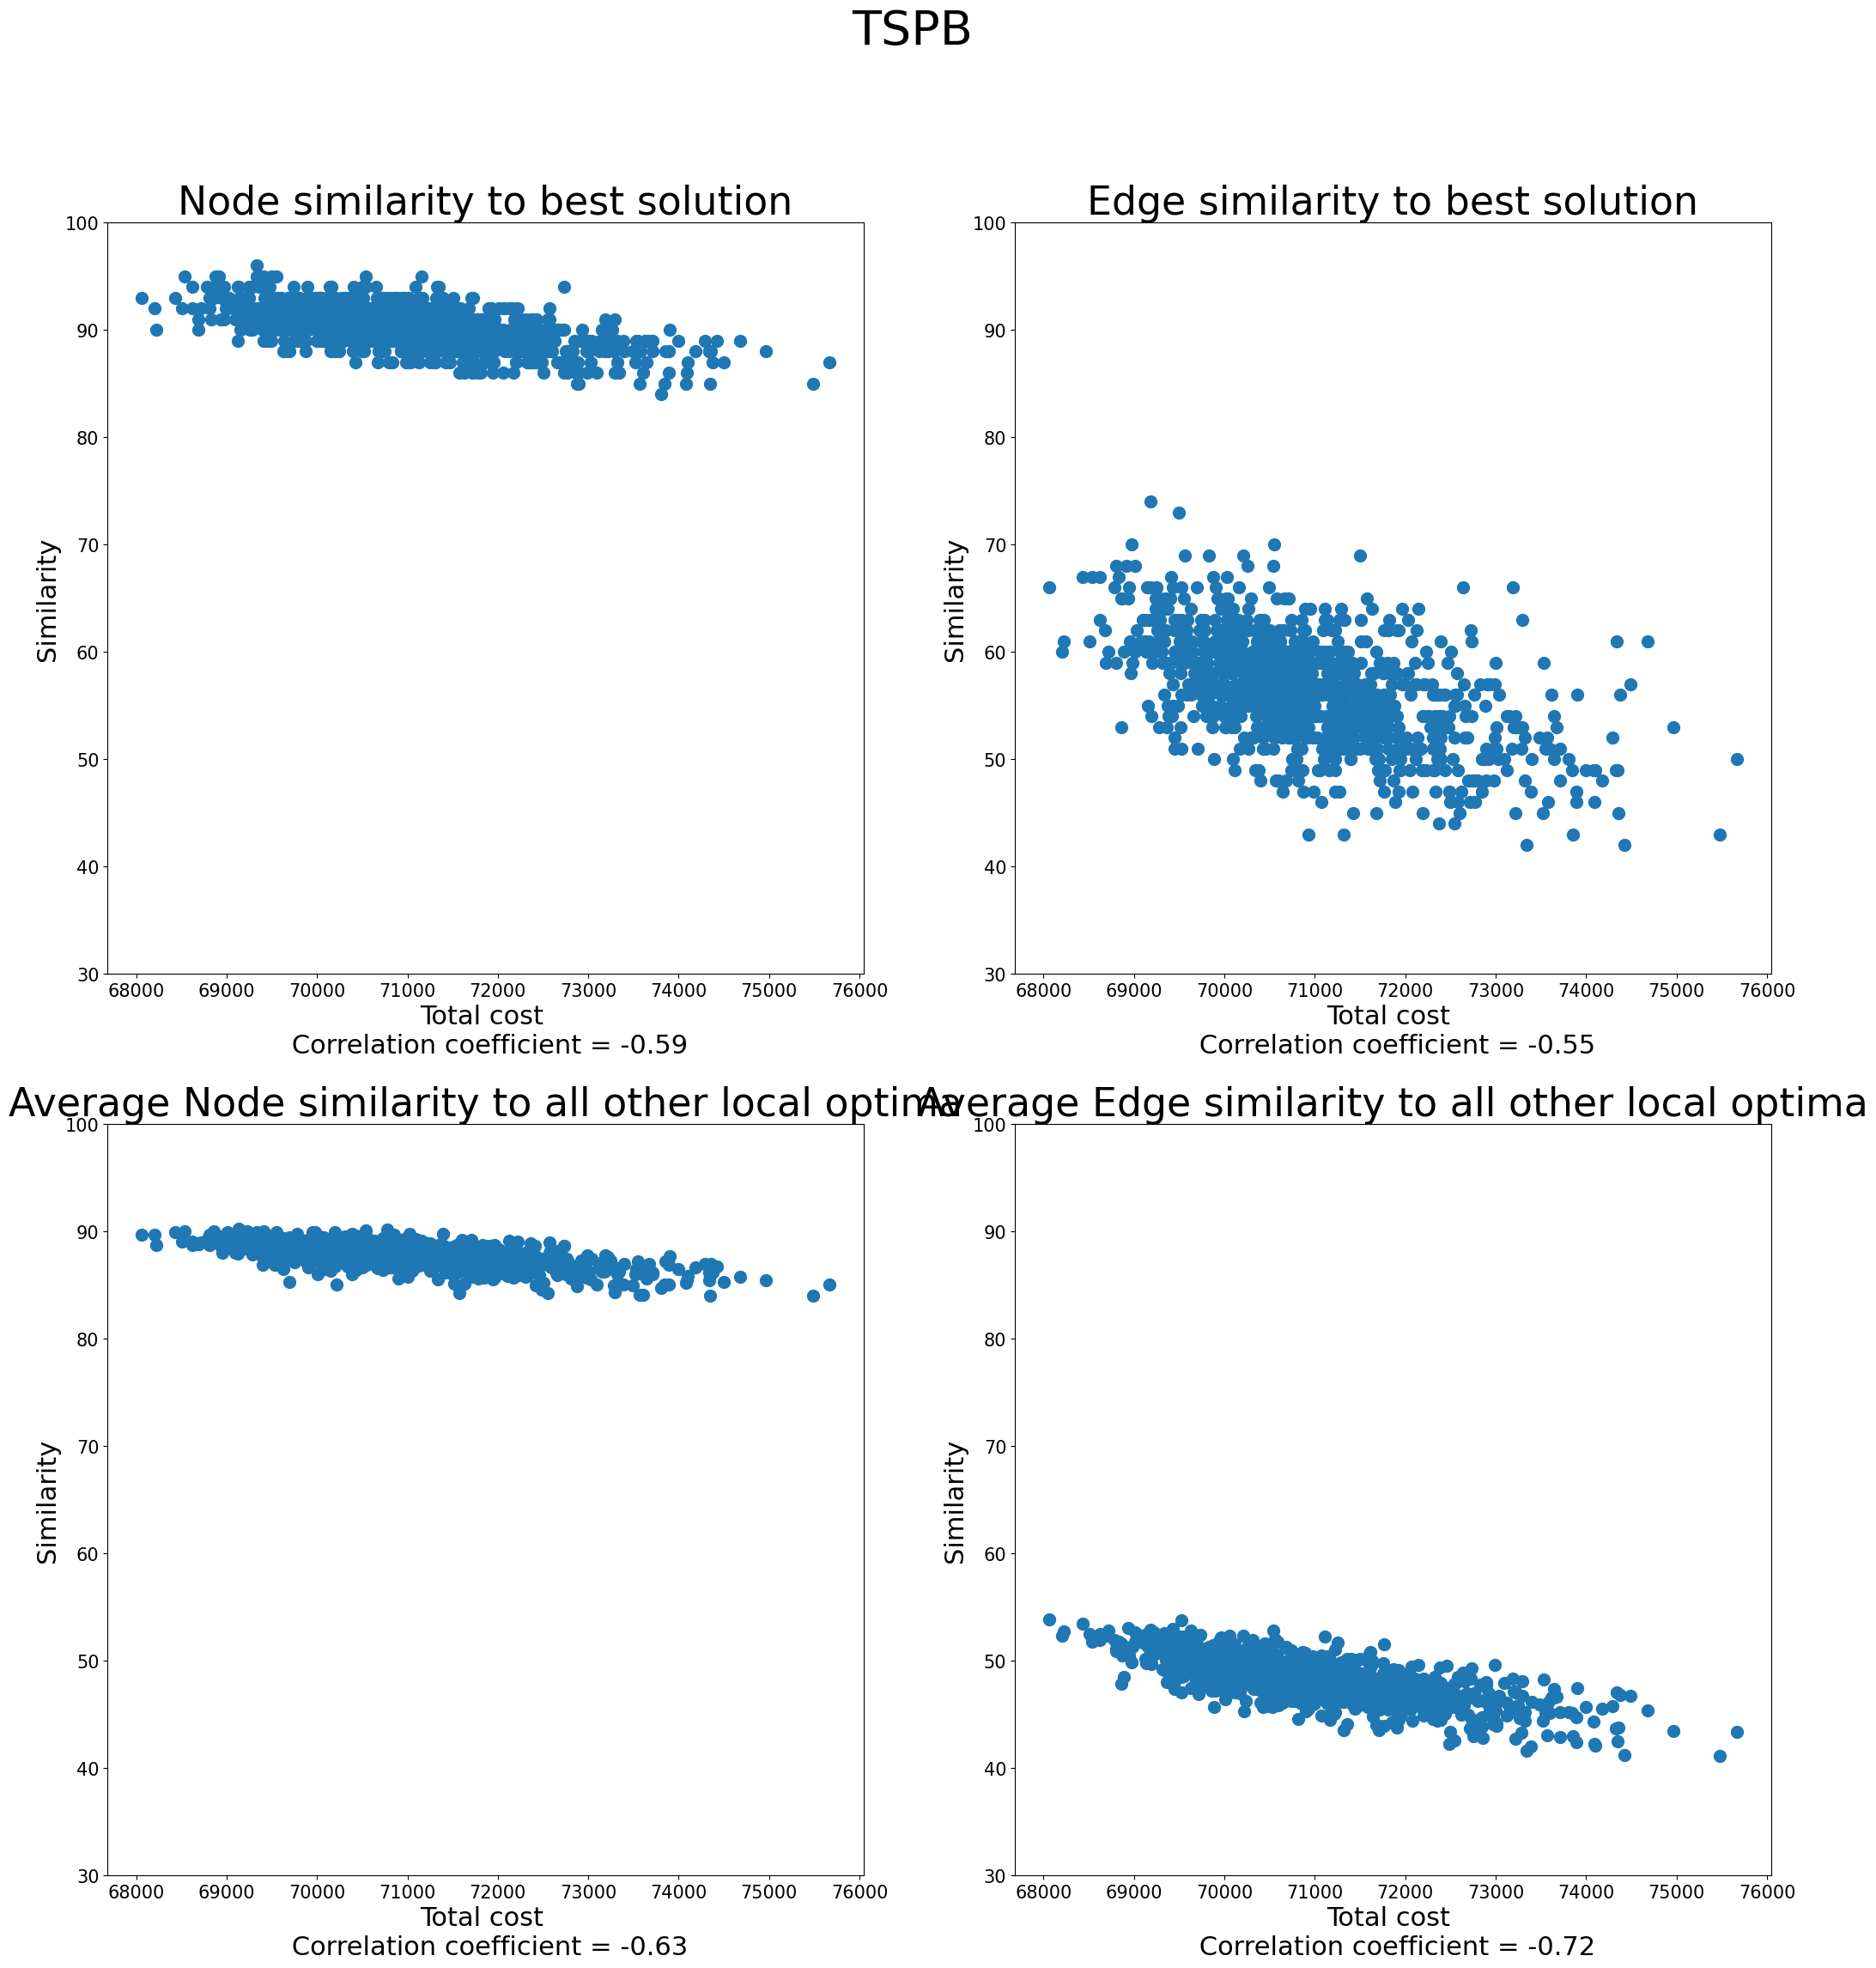

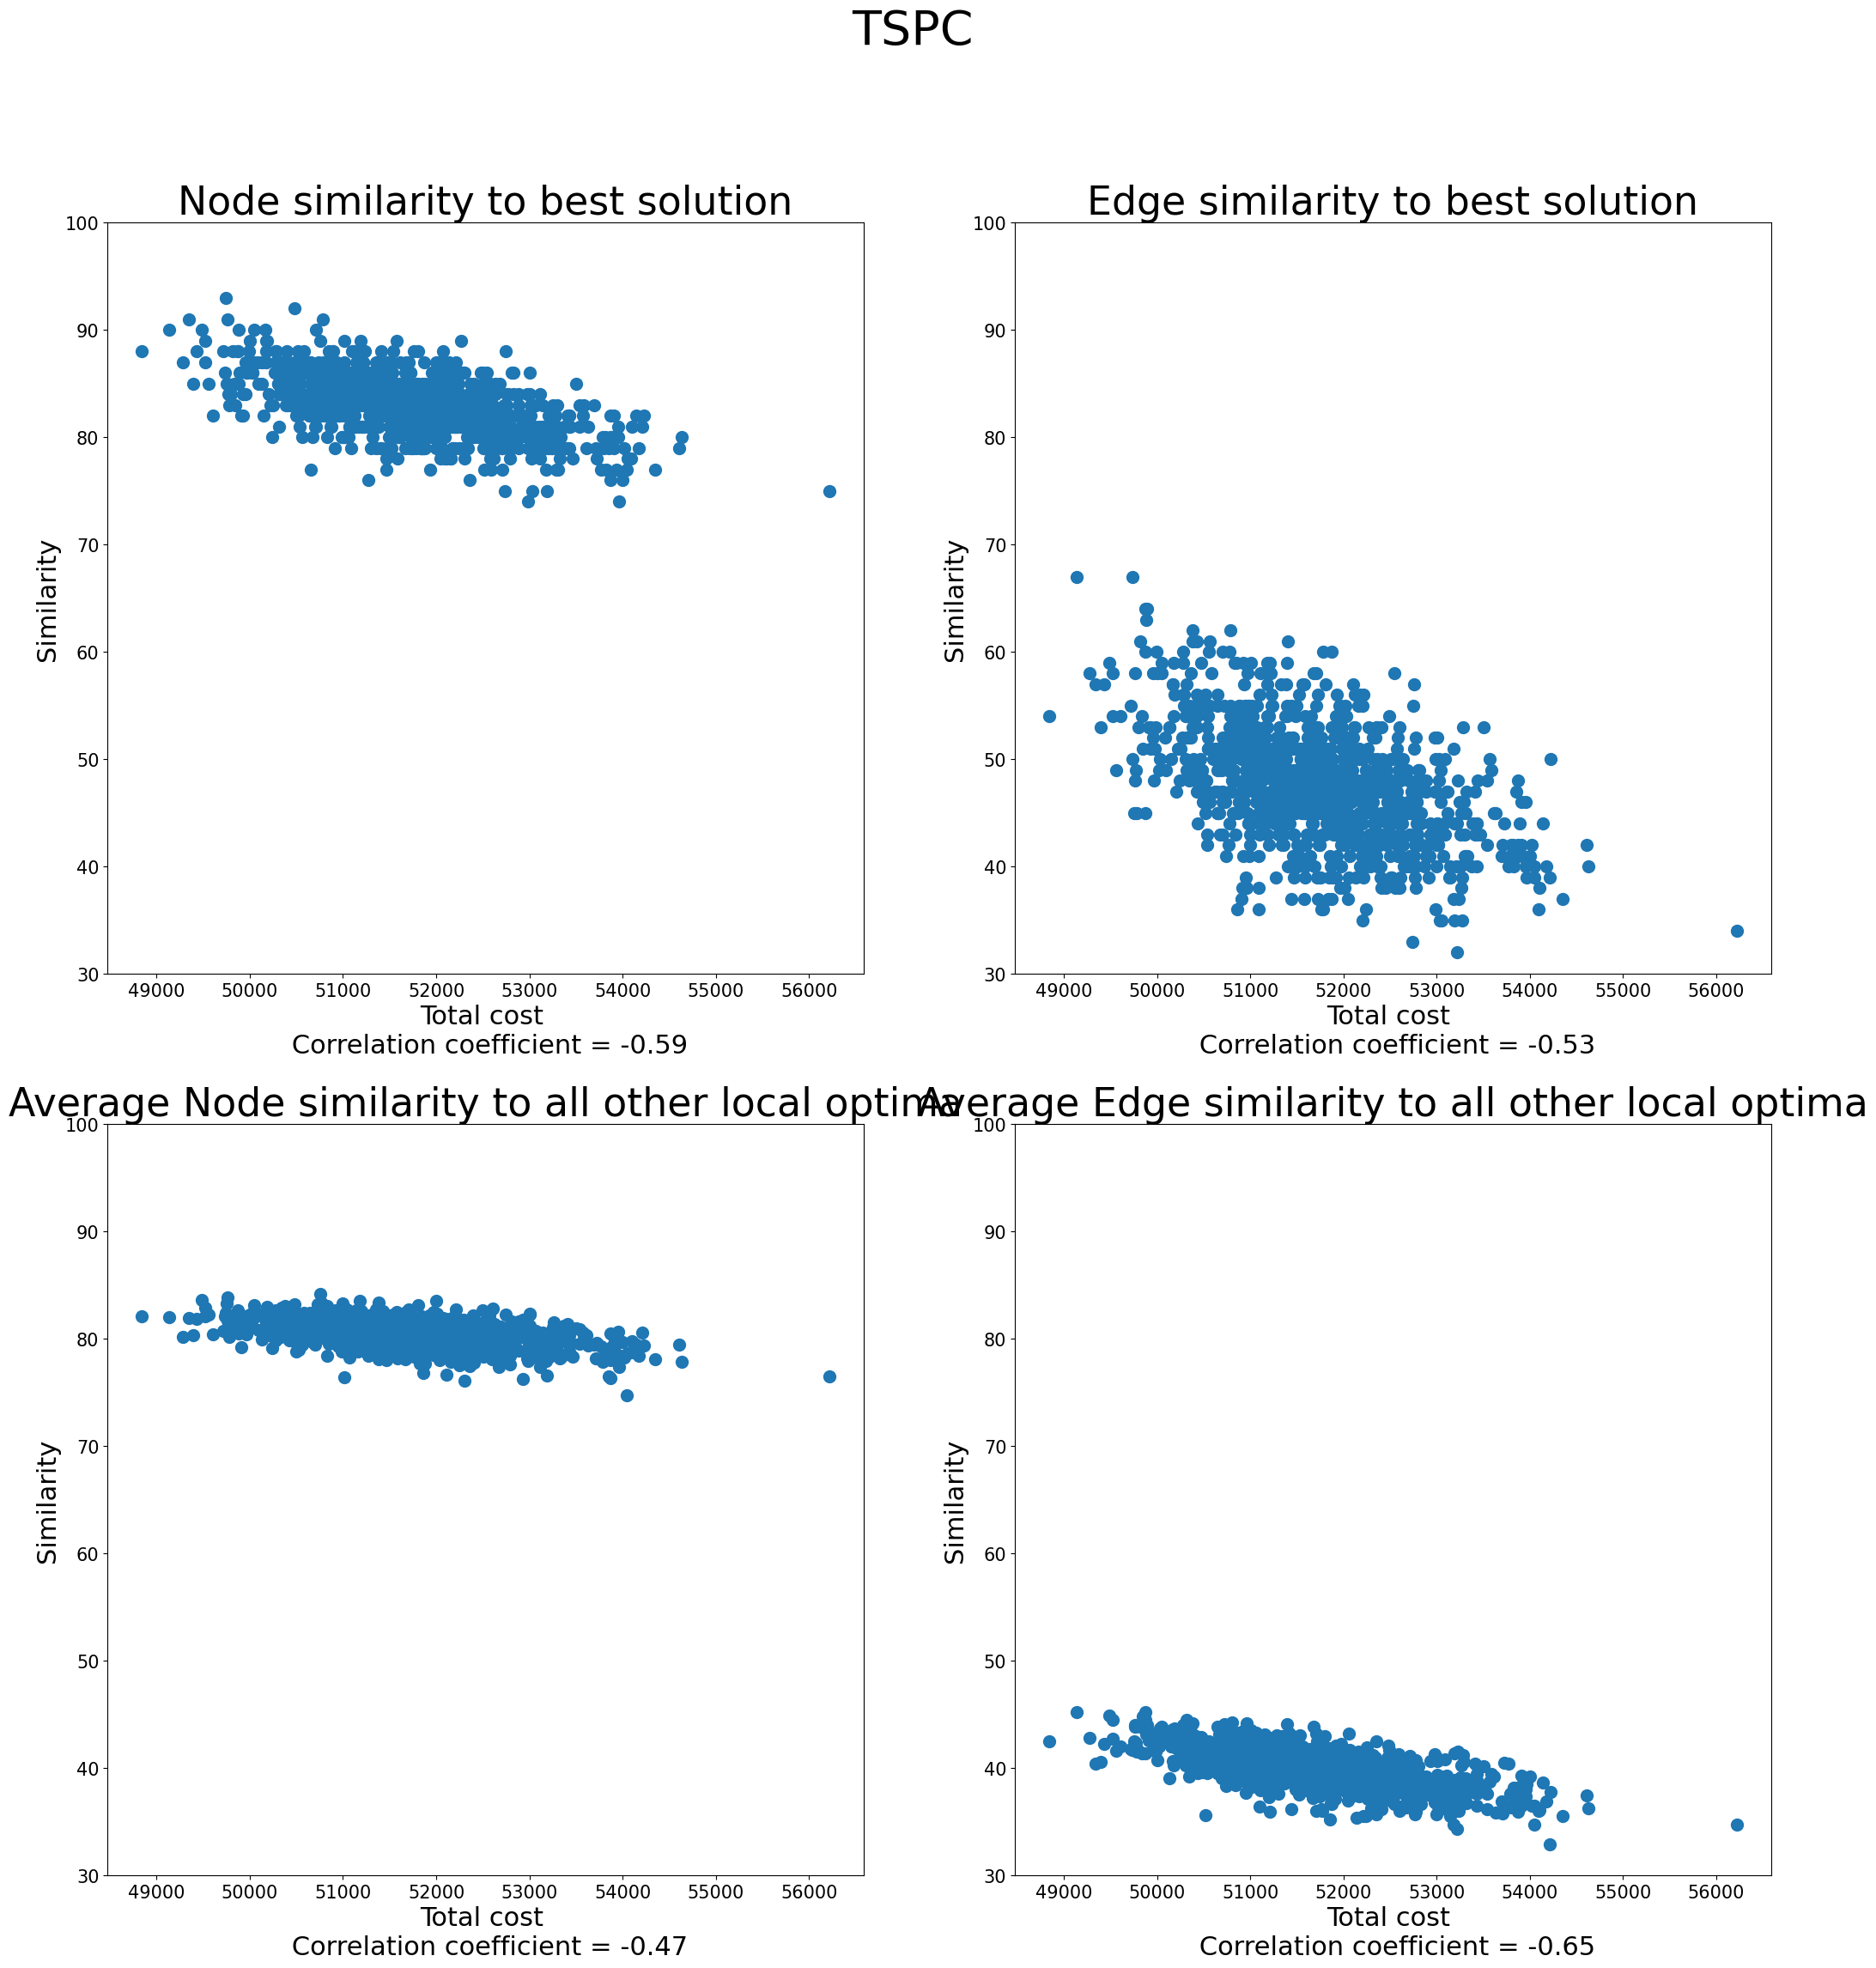

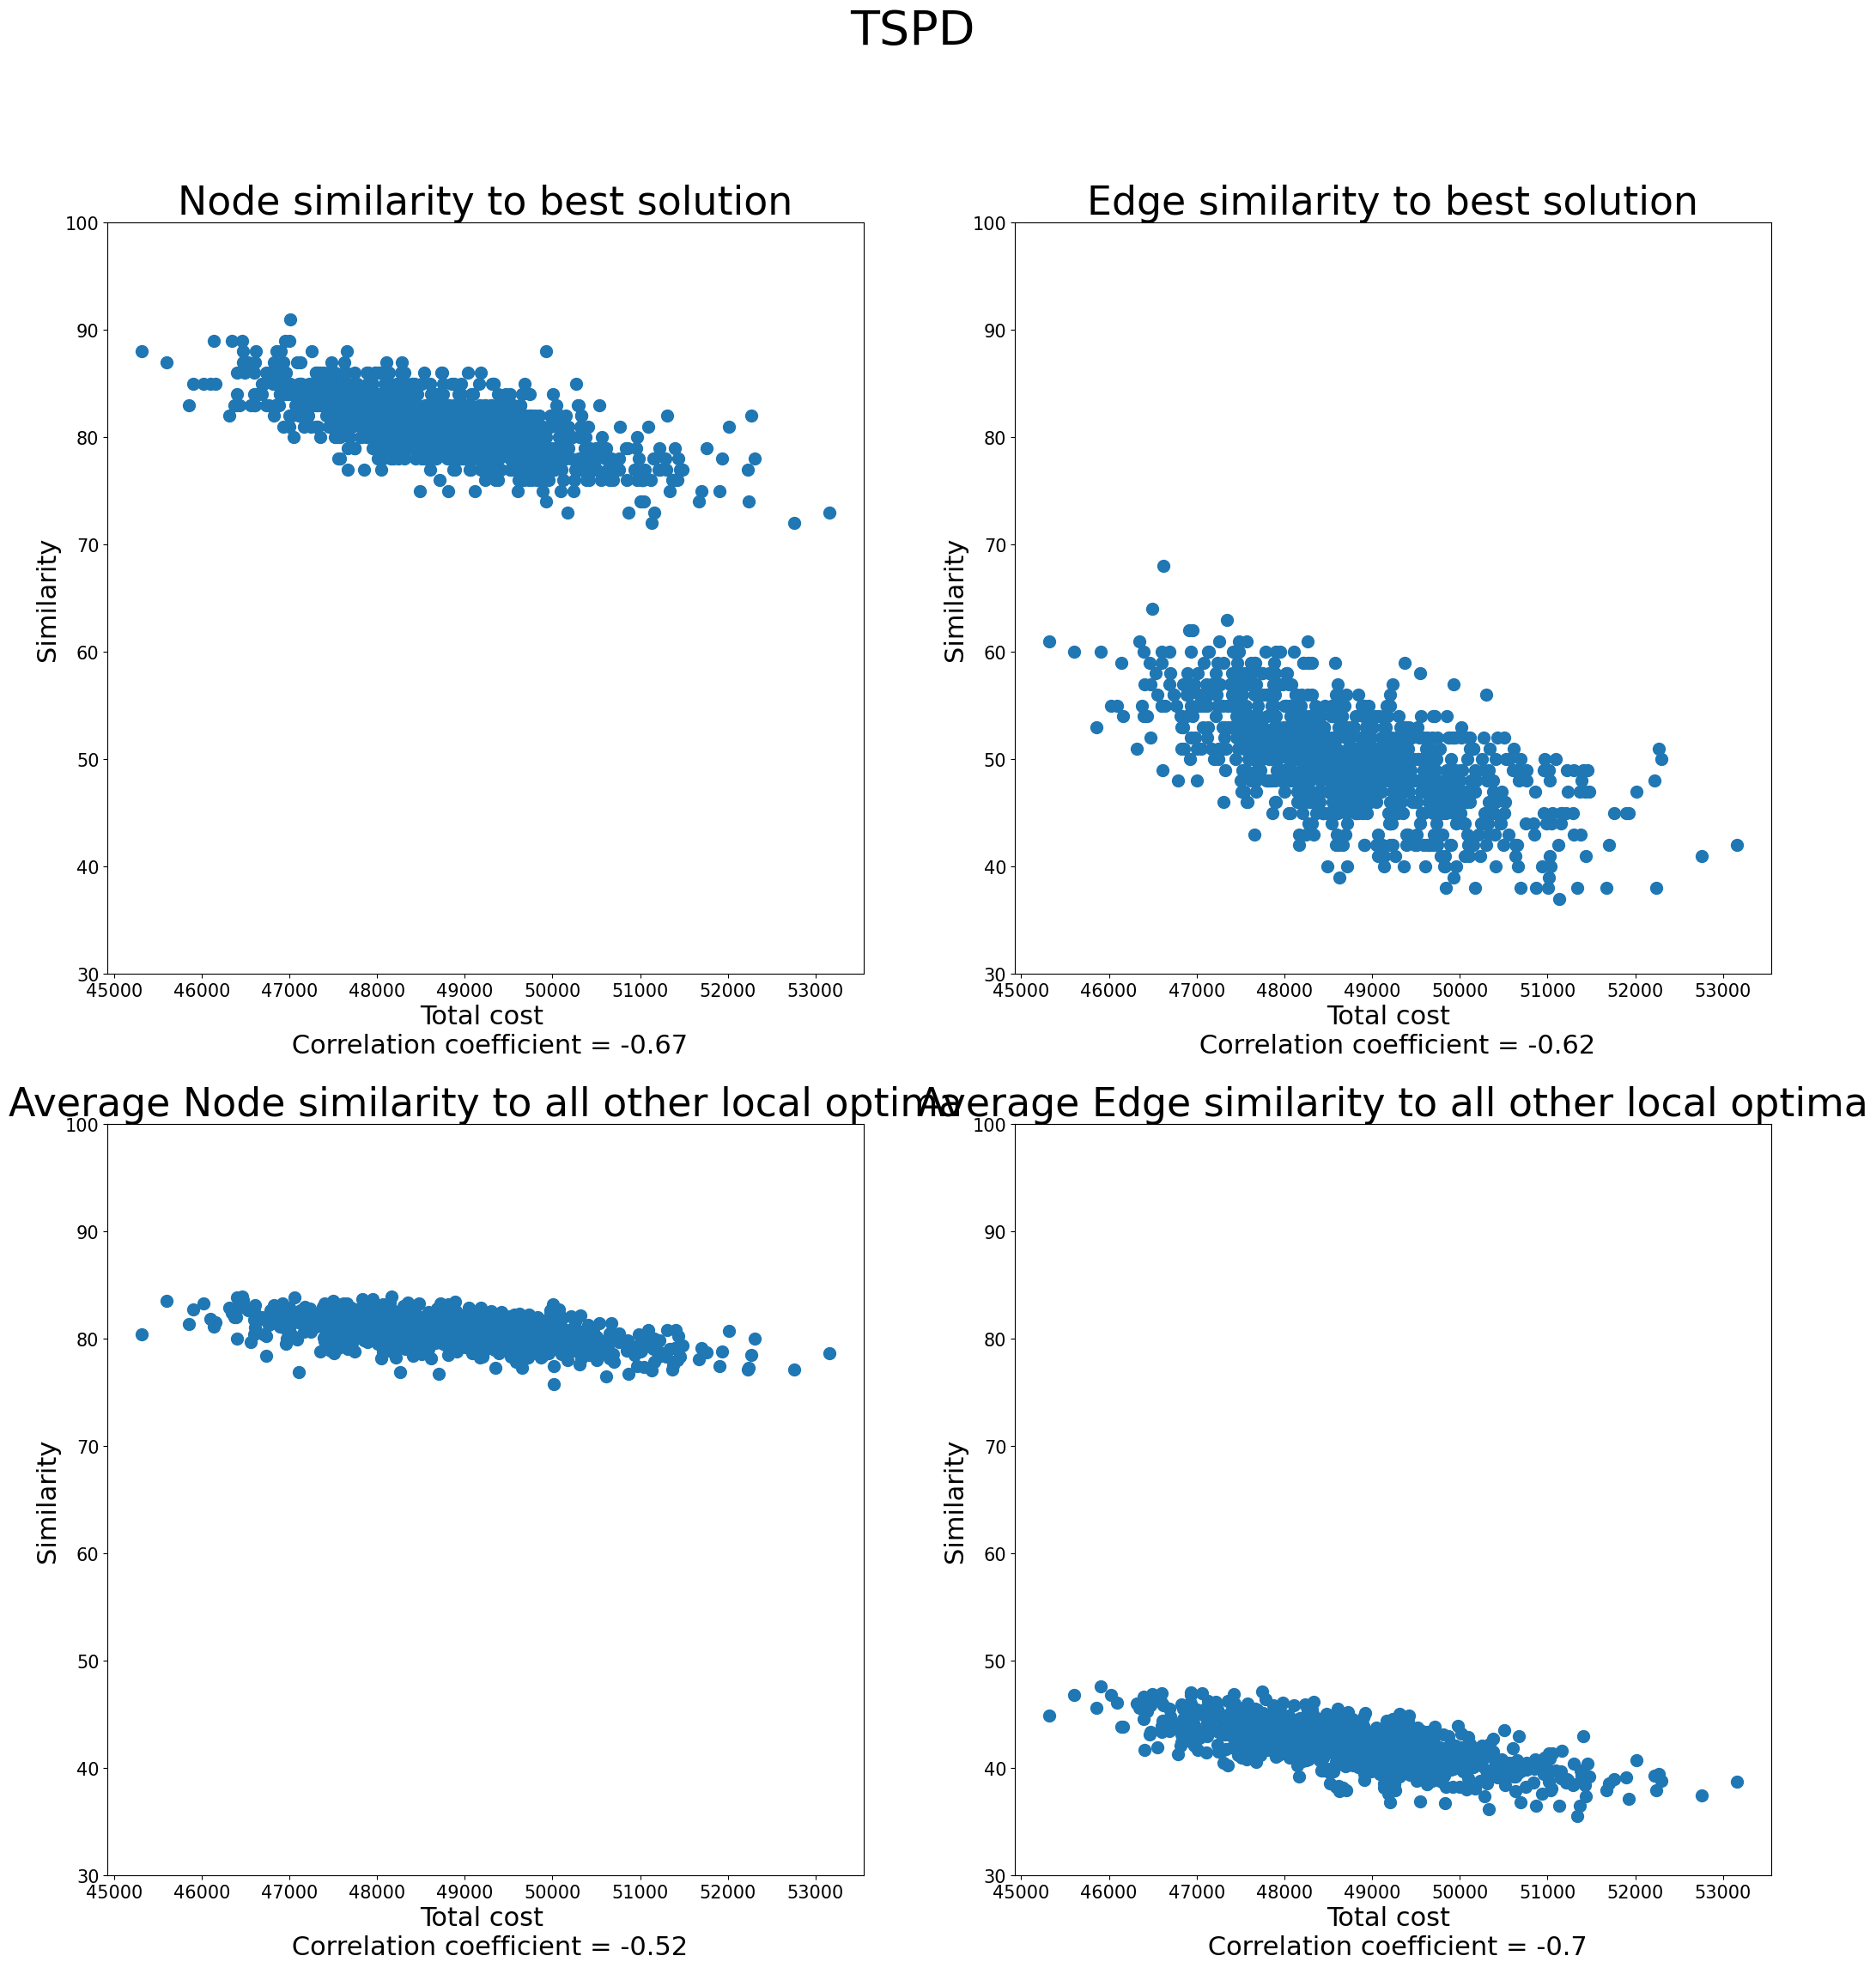

In [36]:
for instance in ('A', 'B', 'C', 'D'):
    with open(f"./results/TSP{instance}_res.pkl", "rb") as file:
        data = pickle.load(file)
    get_plots(f'TSP{instance}', data) 